# Installation

In [56]:
import os
import shutil
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from google.colab import drive, files
from PIL import Image

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Copy dataset from Google Drive to local storage
# https://drive.google.com/drive/folders/1qOq7eZEkpneazm0lFiAkK0bTkviuszff?usp=drive_link
for folder in ['digits', 'letters']:
    local_data_path = f'/content/{folder}'
    if not os.path.exists(local_data_path):
        shutil.copytree(f'/content/drive/MyDrive/Dataset/{folder}', local_data_path)

# Custom Datasets and Noises

In [43]:
# Custom transformation for Salt-and-Pepper noise
class AddSaltPepperNoise:
    def __init__(self, salt_prob=0.01, pepper_prob=0.01):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def __call__(self, tensor):
        img = tensor.numpy()
        noise = np.random.random(img.shape)
        img[noise < self.salt_prob] = 1.0
        img[noise > (1 - self.pepper_prob)] = 0.0
        return torch.from_numpy(img)

    def __repr__(self):
        return self.__class__.__name__ + '(salt_prob={0}, pepper_prob={1})'.format(self.salt_prob, self.pepper_prob)

# Custom Dataset class for binary labels
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None, label=0):
        self.dataset = datasets.ImageFolder(root=root, transform=transform)
        self.label = label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, _ = self.dataset[index]
        return image, self.label

# Neural Network for Binary Classification

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Single output for sigmoid

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = torch.sigmoid(x)  # Sigmoid activation
        return output

# Training Function

In [45]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = (output >= 0.5).float()
        correct += pred.eq(target).sum().item()

        if batch_idx % args.log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

# Test Function

In [46]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).float().view(-1, 1)
            output = model(data)
            test_loss += F.binary_cross_entropy(output, target, reduction='sum').item()
            pred = (output >= 0.5).float()
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return test_loss, accuracy

# Train and Evaluate

In [47]:
def train_and_evaluate(args, model, device, train_loader, test_loader, optimizer, scheduler):
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    best_test_loss = float('inf')
    patience = 8
    no_improvement_count = 0

    model_dir = f"Binary_Model_seed_{args.seed}"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    for epoch in range(1, args.epochs + 1):
        train_loss, train_accuracy = train(args, model, device, train_loader, optimizer, epoch)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            no_improvement_count = 0
            if args.save_model and epoch > 1:
                model_filename = f"binary_cnn_epoch:{epoch}_test-accuracy:{test_accuracy:.4f}_test-loss:{test_loss:.4f}.pt"
                model_path = os.path.join(model_dir, model_filename)
                try:
                    torch.save(model.state_dict(), model_path)
                    print(f"Model saved with new best test loss: {best_test_loss:.4f} \n")
                except Exception as e:
                    print(f"Error saving model: {e}")
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"\nEarly stopping triggered after {epoch} epochs. No improvement in test loss for {patience} consecutive epochs.")
            break

        scheduler.step()

    return train_losses, train_accuracies, test_losses, test_accuracies, model_dir  # Return model_dir


# Visualization


## Plot Training Results

In [48]:
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.plot(epochs, test_losses, 'o-', label='Test Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'o-', label='Test Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Plot Samples for Each Class

In [50]:
def visualize_samples(test_loader, model, device, num_samples=3):
    model.eval()
    digit_samples = []
    letter_samples = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            preds = (outputs >= 0.5).float()

            for i in range(len(target)):
                img = data[i].cpu().squeeze().numpy()
                if target[i] == 0 and len(digit_samples) < num_samples:
                    digit_samples.append(img)
                elif target[i] == 1 and len(letter_samples) < num_samples:
                    letter_samples.append(img)
                if len(digit_samples) >= num_samples and len(letter_samples) >= num_samples:
                    break
            if len(digit_samples) >= num_samples and len(letter_samples) >= num_samples:
                break

    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))
    fig.suptitle('Sample Images from Each Class')

    for i in range(num_samples):
        axes[0, i].imshow(digit_samples[i], cmap='gray')
        axes[0, i].set_title('Digit')
        axes[0, i].axis('off')

        axes[1, i].imshow(letter_samples[i], cmap='gray')
        axes[1, i].set_title('Letter')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

## Prediction Function

In [52]:
def make_prediction(model, device, image_path):
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = "Digit" if output.item() < 0.5 else "Letter"
        confidence = output.item() if output.item() >= 0.5 else 1 - output.item()

    print(f"Prediction: {prediction} (Confidence: {confidence:.4f})")

    plt.figure(figsize=(4, 4))
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f"Predicted: {prediction} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

# Main Function

In [53]:
def main():
    random_seed = random.randint(0, 100000)
    print(f"Using random seed: {random_seed}")

    torch.manual_seed(random_seed)
    random.seed(random_seed)

    args = argparse.Namespace(
        batch_size=64,
        test_batch_size=128,
        epochs=500,
        lr=1,
        gamma=0.9,
        no_cuda=False,
        no_mps=False,
        dry_run=False,
        seed=random_seed,
        log_interval=10,
        save_model=True
    )

    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}

    if use_cuda:
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform_train = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomAffine(degrees=(-5,5), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
        transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.01, pepper_prob=0.01)], p=0.2)
    ])

    transform_test = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    digits_path = '/content/digits'
    letters_path = '/content/letters'

    digits_dataset = CustomImageFolder(root=digits_path, transform=transform_train, label=0)
    letters_dataset = CustomImageFolder(root=letters_path, transform=transform_train, label=1)

    combined_dataset = ConcatDataset([digits_dataset, letters_dataset])

    train_size = int(0.8 * len(combined_dataset))
    test_size = len(combined_dataset) - train_size
    train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

    test_dataset.dataset.datasets[0].transform = transform_test
    test_dataset.dataset.datasets[1].transform = transform_test

    train_loader = DataLoader(train_dataset, **train_kwargs)
    test_loader = DataLoader(test_dataset, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    train_losses, train_accuracies, test_losses, test_accuracies, model_dir = train_and_evaluate(args, model, device, train_loader, test_loader, optimizer, scheduler)

    plot_results(train_losses, train_accuracies, test_losses, test_accuracies)

    return model, device, test_loader, model_dir

Using random seed: 44351
Train Epoch: 1 [0/5760 (0%)]	Loss: 0.684825
Train Epoch: 1 [640/5760 (11%)]	Loss: 0.636391
Train Epoch: 1 [1280/5760 (22%)]	Loss: 0.621445
Train Epoch: 1 [1920/5760 (33%)]	Loss: 0.547967
Train Epoch: 1 [2560/5760 (44%)]	Loss: 0.485121
Train Epoch: 1 [3200/5760 (56%)]	Loss: 0.602808
Train Epoch: 1 [3840/5760 (67%)]	Loss: 0.534685
Train Epoch: 1 [4480/5760 (78%)]	Loss: 0.485105
Train Epoch: 1 [5120/5760 (89%)]	Loss: 0.466735

Test set: Average loss: 0.4616, Accuracy: 1097/1440 (76%)

Train Epoch: 2 [0/5760 (0%)]	Loss: 0.559824
Train Epoch: 2 [640/5760 (11%)]	Loss: 0.411370
Train Epoch: 2 [1280/5760 (22%)]	Loss: 0.537968
Train Epoch: 2 [1920/5760 (33%)]	Loss: 0.329957
Train Epoch: 2 [2560/5760 (44%)]	Loss: 0.419344
Train Epoch: 2 [3200/5760 (56%)]	Loss: 0.404492
Train Epoch: 2 [3840/5760 (67%)]	Loss: 0.381754
Train Epoch: 2 [4480/5760 (78%)]	Loss: 0.262081
Train Epoch: 2 [5120/5760 (89%)]	Loss: 0.365481

Test set: Average loss: 0.3291, Accuracy: 1247/1440 (87%)

M

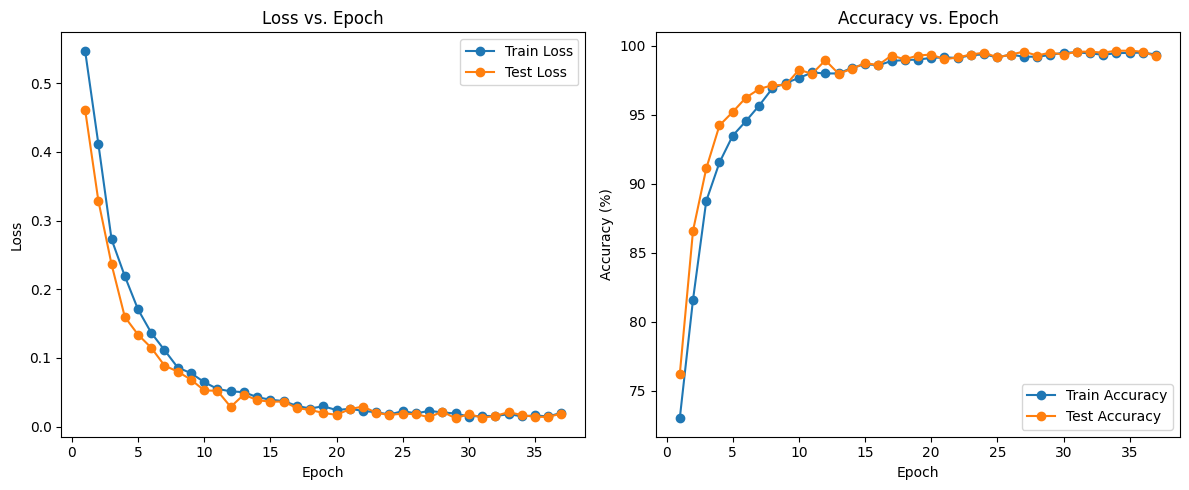

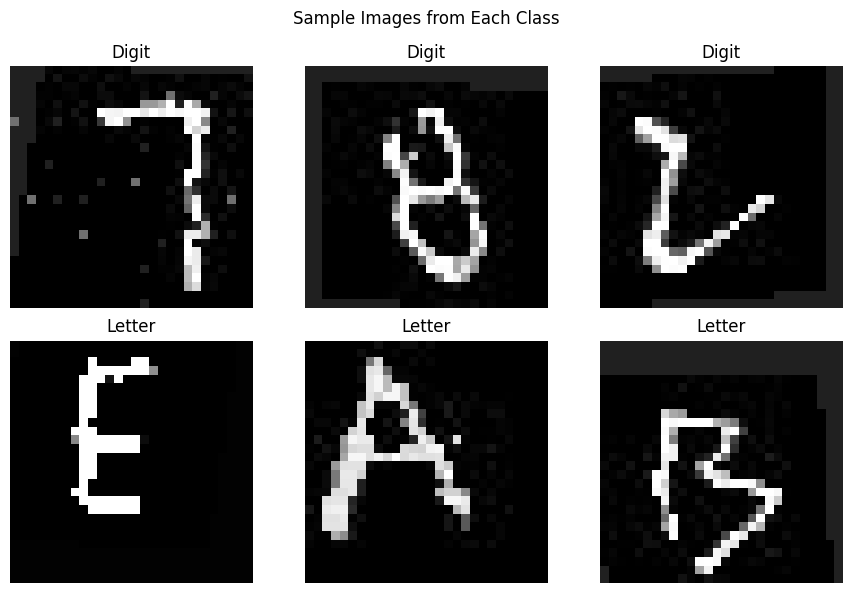

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
if __name__ == '__main__':
    model, device, test_loader, model_dir = main()
    visualize_samples(test_loader, model, device, num_samples=3)
    shutil.make_archive(model_dir, 'zip', model_dir)
    files.download(f'{model_dir}.zip')

Prediction: Digit (Confidence: 1.0000)


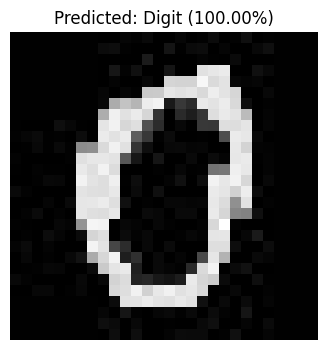

In [57]:
make_prediction(model, device, '/content/digits/0/img1.jpg')